In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#libraries to use the CPU for computation instead of a GPU

### Imports

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load Data

In [3]:
## Loading images and labels,      dataset of flowers using TensorFlow Datasets 



#dataset containing both images and their corresponding labels, and each element is a pair of an image and its associated label.


(train_ds, train_labels), (test_ds, test_labels) = tfds.load("tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,  #entire dataset
    as_supervised=True,  # Include labels
)

### Image Preprocessing

In [4]:
## check existing image size
train_ds[0].shape

TensorShape([442, 1024, 3])

In [5]:
## Resizing images

#After this resizing operation, the train_ds and test_ds datasets will contain images with dimensions of (150, 150) pixels


train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

In [6]:
train_labels

<tf.Tensor: shape=(2569,), dtype=int64, numpy=array([2, 3, 3, ..., 0, 2, 0], dtype=int64)>

In [7]:
## Transforming labels to correct format
#to_catogircal
#It is often used to perform one-hot encoding of class labels, which is a common preprocessing step in classification tasks. 

#one-hot encoded vector represents the class of each data point by setting the corresponding element to 1 and all other elements to 0
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [8]:
train_labels[0]

array([0., 0., 1., 0., 0.], dtype=float32)

### Use Pretrained VGG16 Image Classification model

# **Load a pre-trained CNN model trained on a large dataset**

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [10]:
train_ds[0].shape

TensorShape([150, 150, 3])

In [11]:
## Loading VGG16 model

#base_model: represents the VGG16 model with pre-trained weights. 

# include_top= false: it means that you are not including the top (output) layer of the VGG16 model. The top layer is typically used for ImageNet's 1000-class classification task. 
#By setting it to False, you can use the VGG16 model as a feature extractor and add your own 
#custom classification layers on top of it
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)

In [12]:
## will not train base mode
# Freeze Parameters in model's lower convolutional layers

# base model (VGG16) has its weights frozen, and custom layers are added on top of it. 
#The custom layers are then trained on the specific classification task, while the pre-trained VGG16 layers remain unchanged. 

#model that the weights (learned parameters) of the pre-trained base_model should not be updated during training

base_model.trainable = False

In [13]:
## Preprocessing input

#used to preprocess or normalize the input data to match the requirements of the pre-trained model.


train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

In [14]:
## model details
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

**Add custom classifier with two dense layers of trainable parameters to model**

In [15]:
#add our layers on top of this model
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu') #50-  neurons in the fully connected (Dense) layers
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')



#The base_model (VGG16) is the first layer, which will take the pre-processed image data and extract features from it. 
#Then, the feature vectors will flow through the other layers you defined (flatten, dense_layer_1, dense_layer_2, 
#and prediction_layer) in sequence.
model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

**Train classifier layers on training data available for task**

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',       #loss function for multi-class classification tasks where you have multiple classes
    metrics=['accuracy'],
)

In [17]:
#EarlyStopping callback is particularly useful for preventing overfitting and for efficiently training models

#monitoring the validation accuracy (val_accuracy). The training process will be stopped if this metric doesn't improve.



es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [18]:
history=model.fit(train_ds, train_labels, epochs=10, validation_split=0.2, batch_size=32, callbacks=[es])

#value of 0.2 means that 20% of the training data will be set aside for validation, and the remaining 80% will be used for training. 
#Validation data is used to monitor the model's performance during training.

#A batch size of 32 means that 32 data points are processed together in each iteration.

Epoch 1/10
65/65 [==============================] - 335s 5s/step - loss: 1.6747 - accuracy: 0.4370 - val_loss: 1.2663 - val_accuracy: 0.5272
Epoch 2/10
65/65 [==============================] - 360s 6s/step - loss: 0.9770 - accuracy: 0.6200 - val_loss: 1.1817 - val_accuracy: 0.6187
Epoch 3/10
65/65 [==============================] - 360s 6s/step - loss: 0.6958 - accuracy: 0.7343 - val_loss: 1.0484 - val_accuracy: 0.6693
Epoch 4/10
65/65 [==============================] - 365s 6s/step - loss: 0.5428 - accuracy: 0.8049 - val_loss: 0.9924 - val_accuracy: 0.6868
Epoch 5/10
65/65 [==============================] - 357s 6s/step - loss: 0.4166 - accuracy: 0.8584 - val_loss: 0.9848 - val_accuracy: 0.6751
Epoch 6/10
65/65 [==============================] - 358s 6s/step - loss: 0.3265 - accuracy: 0.8803 - val_loss: 0.9648 - val_accuracy: 0.7062
Epoch 7/10
65/65 [==============================] - 381s 6s/step - loss: 0.2535 - accuracy: 0.9148 - val_loss: 1.1277 - val_accuracy: 0.6907
Epoch 8/10
65

In [19]:
los,accurac=model.evaluate(test_ds,test_labels)
print("Loss: ",los,"Accuracy: ", accurac)

35/35 [==============================] - 165s 5s/step - loss: 0.0908 - accuracy: 0.9755
Loss:  0.09077514708042145 Accuracy:  0.975476861000061


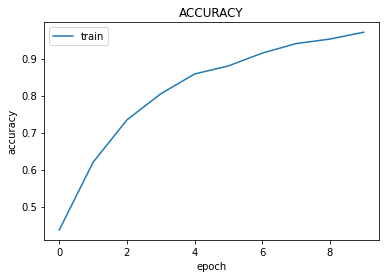

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('ACCURACY')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

In [21]:
import numpy as np
import pandas as pd
y_pred = model.predict(test_ds)
y_classes = [np.argmax(element) for element in y_pred]
#to_categorical(y_classes, num_classes=5)
#to_categorical(test_labels, num_classes=5)
print(y_classes[:10])
print("\nTest")
print(test_labels[:10])

35/35 [==============================] - 163s 5s/step
[2, 3, 3, 4, 3, 0, 0, 0, 0, 1]

Test
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


The steps you described are a typical workflow for transfer learning using a pre-trained Convolutional Neural Network (CNN) model, such as VGG16 or ResNet, for a specific task. Here's an explanation of each step:

a. **Load in a pre-trained CNN model trained on a large dataset**:
   - In this step, you select a pre-trained CNN model that has been trained on a large and diverse dataset, such as ImageNet. These models have already learned meaningful features and representations from a wide range of images, which you can leverage for your specific task.

b. **Freeze parameters (weights) in the model’s lower convolutional layers**:
   - After loading the pre-trained model, you typically freeze (make non-trainable) the parameters (weights and biases) in the lower layers of the model. These layers serve as feature extractors and capture general image features. Freezing them prevents their weights from being updated during training and retains the pre-trained knowledge.

c. **Add a custom classifier with several layers of trainable parameters to the model**:
   - On top of the pre-trained feature extractor, you add a custom classifier. This classifier consists of one or more layers that are trainable. These layers are specific to your task and adapt the learned features to the requirements of your problem.
   - Common layers in the custom classifier include fully connected (dense) layers, dropout layers, and activation functions.

d. **Train the classifier layers on the training data available for the task**:
   - You train the custom classifier layers on your task-specific training data. This data includes both input data (e.g., images) and their corresponding labels.
   - During training, the model learns to make predictions based on the features extracted by the pre-trained layers and the specific patterns relevant to your task.

e. **Fine-tune hyperparameters and unfreeze more layers as needed**:
   - Once the custom classifier has been trained for some time, you can fine-tune hyperparameters, such as learning rates, batch sizes, and data augmentation strategies, to improve performance.
   - If necessary, you can gradually unfreeze some of the previously frozen lower layers in the pre-trained model. This allows these layers to be updated during training to adapt to your task. Unfreezing a few layers at a time is common, as it helps to avoid losing the valuable knowledge stored in the pre-trained weights.

The advantage of this approach is that it combines the strengths of the pre-trained model's feature extraction capabilities with task-specific learning in the custom classifier. This is particularly useful when you have a limited amount of data for your specific task, as the pre-trained features provide a strong foundation. By fine-tuning and adjusting the custom classifier, you can adapt the model to perform well on your target task, whether it's image classification, object detection, or any other computer vision task.